### Import Packages

In [10]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from dl.make_image_data import species, removals
import os
from torchvision.io import read_image
from torchvision.transforms.functional import get_image_size, get_image_num_channels
from sklearn.model_selection import train_test_split



In [ ]:
os.chdir("../..")

In [27]:
def create_df_from_all_images(root):
    sources = []
    labels = []
    species = []
    
    for folder in os.listdir(root):
        splitted_folder = folder.split('___')
        specie = splitted_folder[0]
        label_ = splitted_folder[1]
        
        if label_ == 'healthy':
            label = 'healthy'
        else:
            label = 'diseased'
        
        folder_path = root + "/" + folder
        for image in os.listdir(folder_path):
            if len(specie.split("_")) > 1:
                specie_ = specie.split("_")[0]
                source = str(f"{root}/{specie}___{label_}/{image}")
                sources.append(source)
                labels.append(label)
                species.append(specie_)
            else:
                source = str(f"{root}/{specie}___{label_}/{image}")                
                sources.append(source)
                labels.append(label)
                species.append(specie)
            
    df = pd.DataFrame(
        {
            "source" : sources,
            "label" : labels,
            "specie": species
        }
    )
    
    return df

def drop_incorrect_images_from_metadata(df:pd.DataFrame, expected_img_size:list, expected_nr_channels:int) -> pd.DataFrame:
    expected_image_size = expected_img_size
    expected_nr_channels = expected_nr_channels
    
    for i in range(len(df)):
        image = read_image(df.loc[i, "source"])
        actual_image_size = get_image_size(image)
        actual_channels = get_image_num_channels(image)
    
        if expected_image_size != actual_image_size or expected_nr_channels != actual_channels:
            df = df.drop(i)
    
    return df.reset_index(drop=True)


# Function to remove images for specified species
def remove_images_for_species(df, species, count):
    df = df.copy()
    species_rows = df[(df['label'] == 'diseased') & (df['specie'] == species)]
    rows_to_remove = species_rows.sample(n=int(count), random_state=42)
    df = df.drop(rows_to_remove.index) 
    return df.reset_index(drop=True)
 

def remove_removals(df, removals):
    df = df.copy()
    for species, count in removals.items():
        df = remove_images_for_species(df, species, count)
    return df

def select_chosen_species(df,species):
    df = df.copy()    
    df = df.loc[df['specie'].isin(species)]
    
    return df.reset_index(drop = True)


def split_image_data(df):
    df = df.copy()
    X = df.loc[:, ["source", "specie"]]
    y = df.drop(["source", "specie"], axis=1)

    # train en test set maken - 0.2 test - stratify zorgt ervoor dat de verhouding DS en HL hetzelfde is in training en test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # validatie set aanmaken - 0.5 van test set 
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

    # join de labels met metadata
    all_data = X.merge(y, left_index=True, right_index=True).reset_index(drop=True)
    train_data = X_train.merge(y_train, left_index=True, right_index=True).reset_index(drop=True)
    test_data = X_test.merge(y_test, left_index=True, right_index=True).reset_index(drop=True)
    val_data = X_val.merge(y_val, left_index=True, right_index=True).reset_index(drop=True)
    
    return all_data, train_data, test_data, val_data

### Import data

In [36]:
df = create_df_from_all_images('./data/raw/color')
    
df = select_chosen_species(df, species)

df = drop_incorrect_images_from_metadata(df, [256,256], 3)

# df = remove_removals(df, removals)

all_data, train, test, val = split_image_data(df)

In [37]:
all_data.head()

,source,specie,label
0,./data/raw/color/Peach___healthy/2e9b1f70-53cb...,Peach,healthy
1,./data/raw/color/Peach___healthy/0ccb71ac-bf4e...,Peach,healthy
2,./data/raw/color/Peach___healthy/39d9ccd9-56ee...,Peach,healthy
3,./data/raw/color/Peach___healthy/70effb6b-66f1...,Peach,healthy
4,./data/raw/color/Peach___healthy/5d994e9c-adc0...,Peach,healthy


### Visualizations

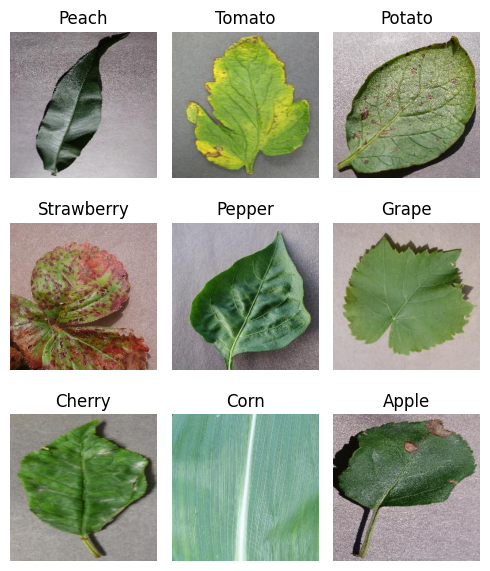

In [38]:
### Display sample images for each specie
num_classes = len(all_data['specie'].unique())
num_images_per_row = 3
num_rows = (num_classes + num_images_per_row - 1) // num_images_per_row

plt.figure(figsize=(5, 2 * num_rows))  

for i, plant_class in enumerate(all_data['specie'].unique()):
    plt.subplot(num_rows, num_images_per_row, i + 1)
    
    # Inside the loop for displaying sample images
    selected_path = all_data[all_data['specie'] == plant_class]['source'].iloc[0]

    # Check if the image exists and can be loaded
    if os.path.exists(selected_path):
        sample_image = cv2.imread(selected_path)
        if sample_image is not None:
            plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
            plt.title(plant_class)
            plt.axis('off')
        else:
            print(f"Error: Unable to load image from path: {selected_path}")
    else:
        print(f"Error: Image path does not exist: {selected_path}")

plt.tight_layout()
plt.show()

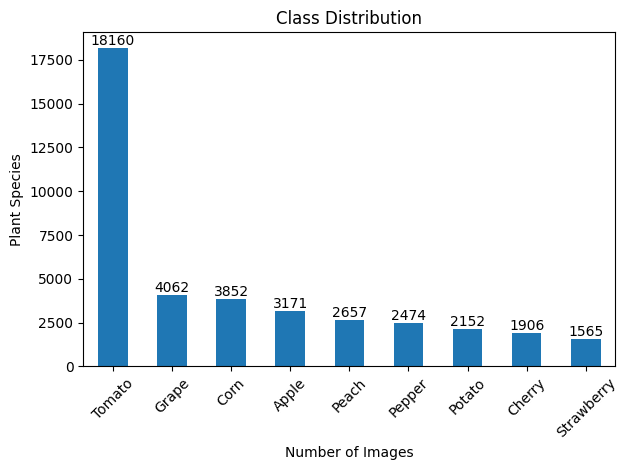

In [39]:
### Visualize total number of images per specie
# Count images per specie
specie_counts = all_data['specie'].value_counts()

# Plotting
specie_counts.plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel('Number of Images')
plt.ylabel('Plant Species')
plt.xticks(rotation=45)
plt.tight_layout()

# Adding text annotations to each bar
for i, v in enumerate(specie_counts.values):
    plt.text(i, v + 5, str(v), ha='center', va='bottom')

plt.show()

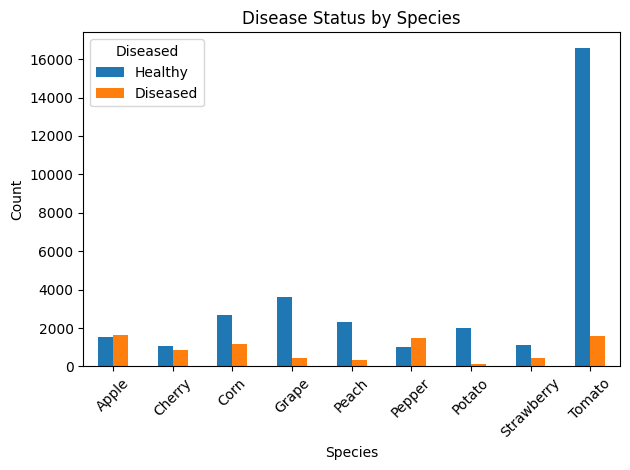

In [45]:

### Visualize the amount of diseased and healthy images per specie
# Group by species and calculate counts of diseased and healthy specimens
grouped_on_species_and_diseased = all_data.groupby(['specie', 'label']).size().unstack(fill_value=0)

# Plotting
grouped_on_species_and_diseased.plot(kind='bar', stacked=False)
plt.title('Disease Status by Species')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Diseased', labels=['Healthy', 'Diseased'])
plt.tight_layout()
    
plt.show()

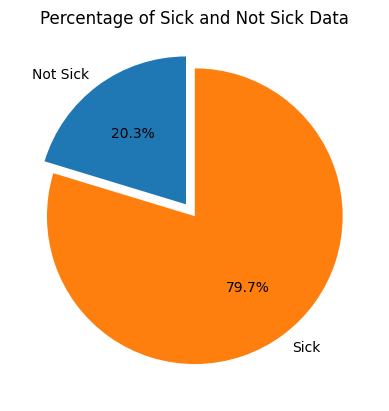

In [41]:
### Make chart to check balance of data
not_sick_percentage = len(all_data[all_data['label'] == 'healthy']) / len(all_data) * 100
sick_percentage = len(all_data[all_data['label'] == 'diseased']) / len(all_data) * 100

# Plotting
labels = ['Not Sick', 'Sick']
sizes = [not_sick_percentage, sick_percentage]
explode = (0.1, 0) 
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Sick and Not Sick Data')
plt.show()

In [42]:
# How many images do we need to delete to get this specie in balance:
# Total images
total_data = len(all_data)
# Total healthy
total_healthy = len(all_data[all_data['label'] == 'healthy'])
# Desired percentages
desired_sick_percentage = 0.4
# Amount of images to remove
total_images_to_remove = int(total_data-(total_healthy/desired_sick_percentage))

print(f"Number of sick images to delete: {total_images_to_remove}")

Number of sick images to delete: 19699


In [165]:
grouped = grouped_on_species_and_diseased.copy()
grouped["sick_healthy_ratio"] = grouped[0]/grouped[1]

df_filtered = grouped[(grouped[0] <= grouped[1]) & (grouped["sick_healthy_ratio"] < 0.4)].copy()
total_sick = df_filtered[1].sum()
df_filtered["sick_ratios"] = df_filtered[1] / total_sick
df_filtered['images_to_remove'] = df_filtered["sick_ratios"] * total_images_to_remove
df_filtered

diseased,0,1,sick_healthy_ratio,sick_ratios,images_to_remove
species,,,,,
Grape,423,3639,0.116241,0.148500,2925.307529
Peach,360,2297,0.156726,0.093736,1846.504917
Potato,152,2000,0.076000,0.081616,1607.753520
Tomato,1591,16569,0.096023,0.676148,13319.434034
